In [1]:
from Modeling import model
from mygp import gp, kernel
import numpy as np
import batman 
import warnings
import matplotlib.pyplot as pl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pl.style.use('seaborn-deep')

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/Users/tgordon/research/libra/')
from libra import ObservationArchive, nirspec_pixel_wavelengths

In [2]:
# plotting function 

def plot_samples(data, t, title=None, mean_func=None, mean_params=None):
    fig, axs = pl.subplots(1, 2, figsize=(20, 6))
    fig.set_facecolor('white')
    
    for d in data:
        axs[0].plot(t, d, 'o')
    
    for d in data:
        axs[1].plot(t, d/np.median(d), 'o')
        
    if title is not None:
        pl.suptitle(title)
    axs[0].set_xlabel('time (JD)')
    axs[1].set_xlabel('time (JD)')
    axs[0].set_ylabel('flux')
    axs[1].set_ylabel('normalized flux')
    
    if mean_func is not None:
        axs[0].plot(t, mean_func(t, 0, *mean_params))
        
# transit model 

def transit(t, log_off, b, rp, t0, dt):
    
    t = np.array(t)
    T0 = dt*np.sqrt(1-b**2)/(1 - b**2 + rp)
    
    params = batman.TransitParams()
    params.t0 = t0                       
    params.per = 100                      
    params.rp = rp                      
    params.a = params.per/(T0*np.pi)                       
    params.inc = np.arccos(b/params.a)*(180/np.pi)                     
    params.ecc = 0.                      
    params.w = 90. 
    
    u1, u2 = 0.1, 0.3
    d4 = -u2
    d2 = u1 + 2*u2
    d1, d3 = 0, 0
    
    params.u = [u1, u2]                
    params.limb_dark = "quadratic" 
    
    #print(T0, params.per, params.inc, params.a)
    m = batman.TransitModel(params, t)    
    return np.exp(log_off)*m.light_curve(params)

def gauss(t, log_off, _, amp, t0, sig):
    return np.exp(log_off) + amp*np.exp(-((t0-t)**2)/(2*sig))

remove_offset = lambda d: d - np.median(d)

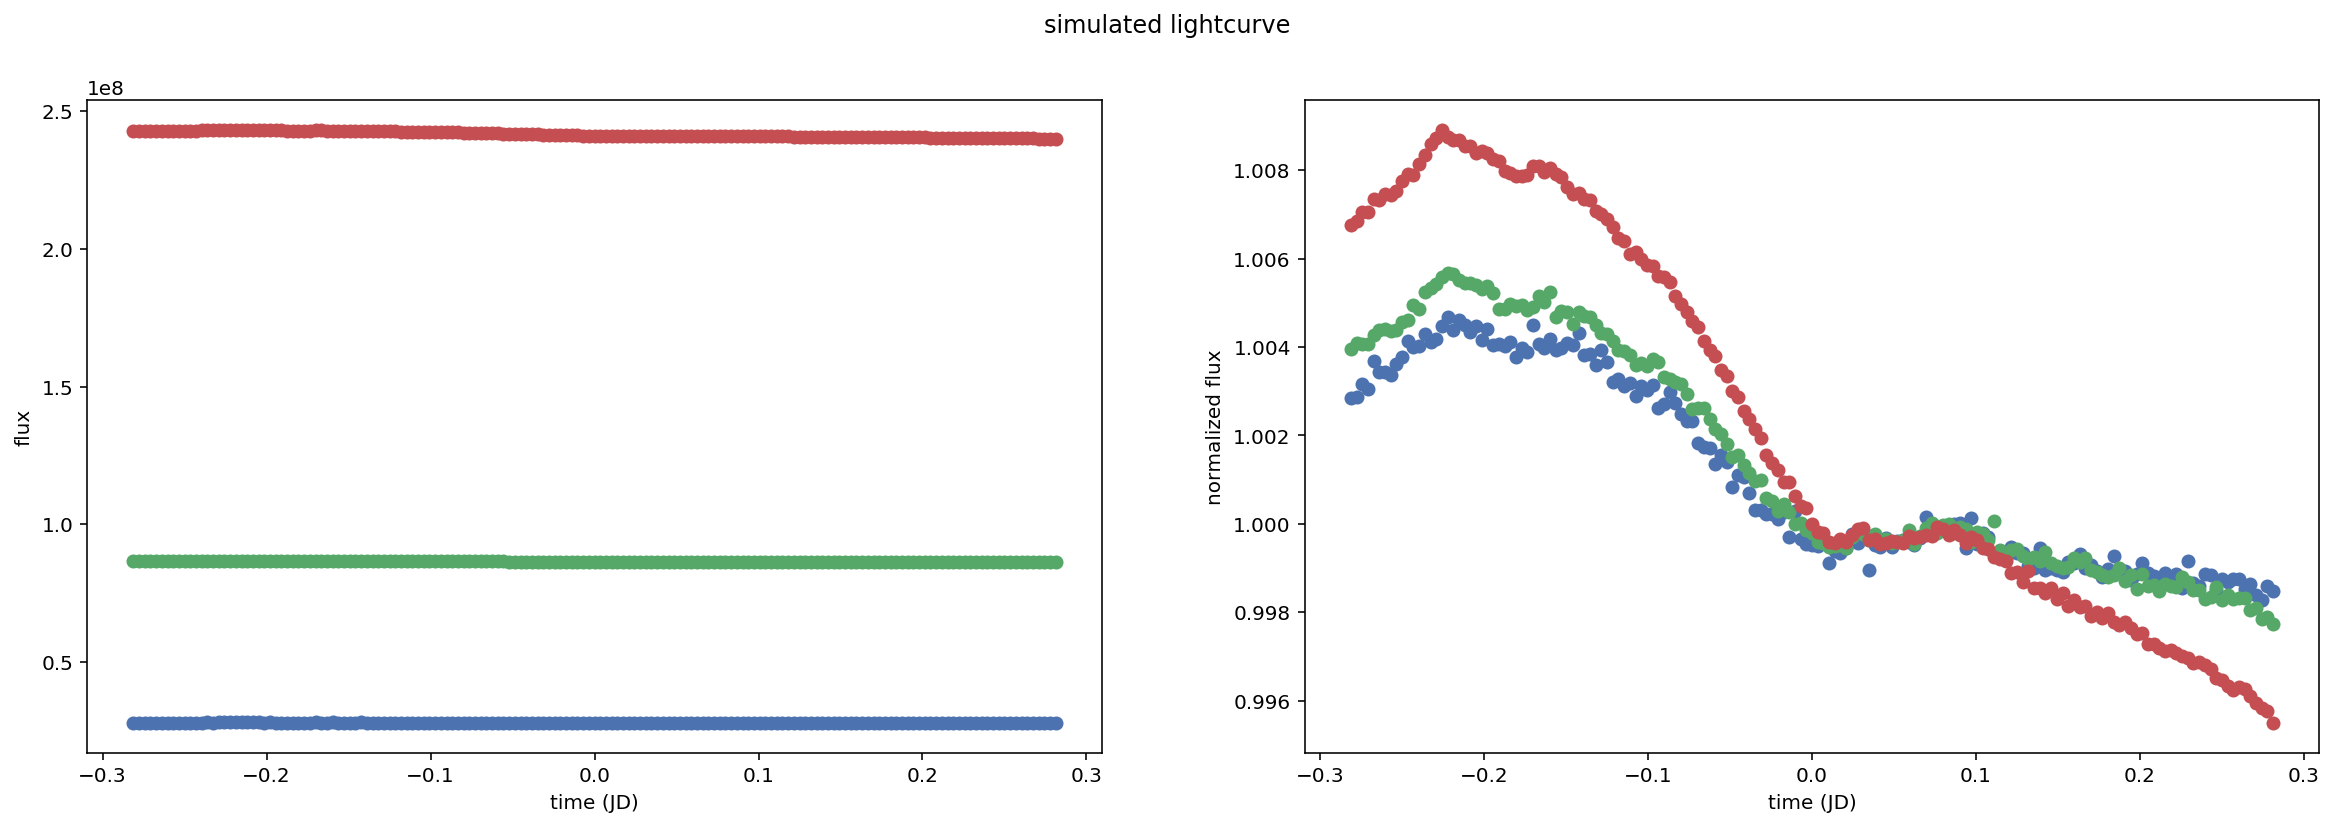

In [4]:
# get and plot data

basedir = '/Users/tgordon/research/libra/notebooks/'
data = np.loadtxt(basedir + 'tyler0_b_binned_small.txt')
t = data[0] - np.median(data[0])

figure = pl.figure(figsize=(12, 10))
data = data[::-1]

plot_samples(data[:-1], t, 'simulated lightcurve')

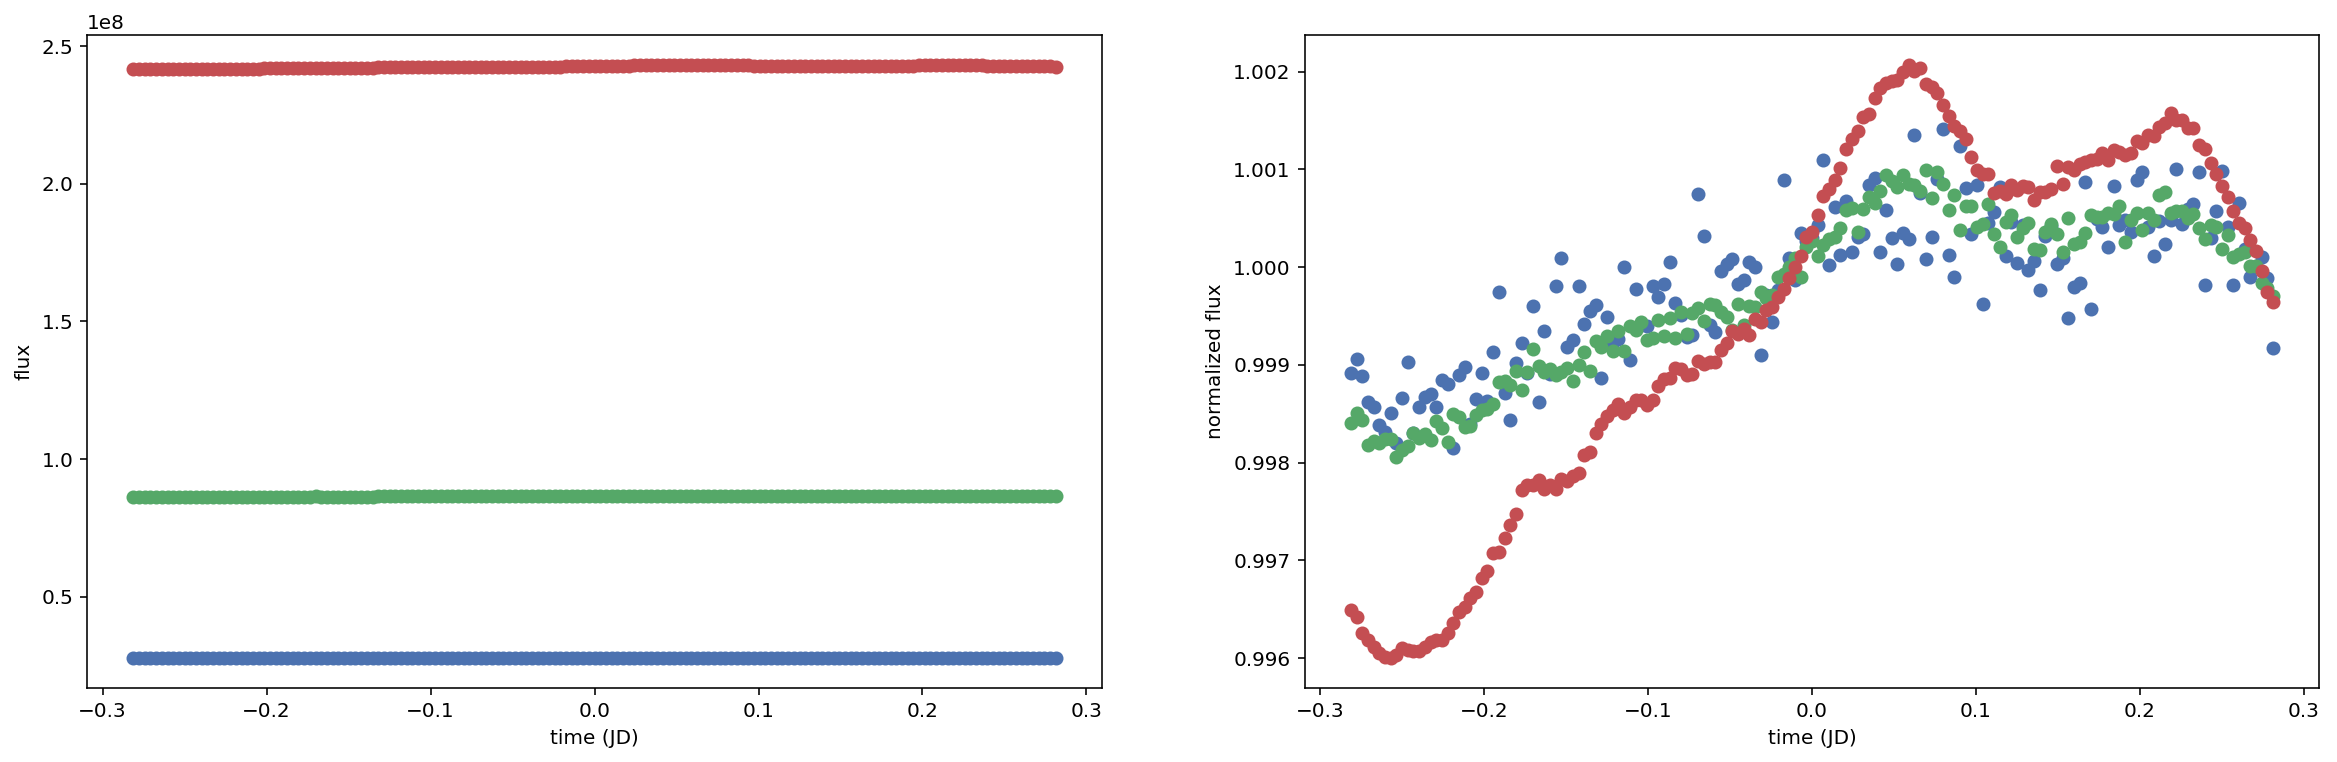

In [10]:
# set up the variability model without a transit and with medians subtracted off
k1_params = [0.5, 1e10, 0.1, 1e8]
k2_params = [1, 4, 25]
white_noise = [1e4]*3
offsets = [np.median(data[0]), np.median(data[1]), np.median(data[2])]

no_transit_model = model(k1_params, k2_params, white_noise, [0], offsets, (lambda x1, x2, x3: x2*np.ones_like(x1)), 
                        kernel.two_celerite_root2_kernel, kernel.scale_kernel, 3)

no_transit_model.gp.compute(t)
samp = no_transit_model.sample(t)

plot_samples(samp, t)

In [11]:
no_transit_model.fit([data[0], data[1], data[2]], t)

(array([ -0.69458696,  23.02621832,  -2.31159767,  18.42296124,
          1.49424773,   3.03442164, -25.        ,   9.22644965,
          9.29730591,   9.2325059 ,  17.11288811,  18.23483275,
         19.23679281]), 5777.517067531333)

k1_params:  [4.99280629e-01 1.00036746e+10 9.91027918e-02 1.00228310e+08]
k2_params:  [ 1.          4.45598319 20.78895096]
mean_params:  [1.38879439e-11]
white_noise:  [10162.39736852 10908.59090043 10224.13013354]
offsets:  [2.70416306e+07 8.30399814e+07 2.26168944e+08]


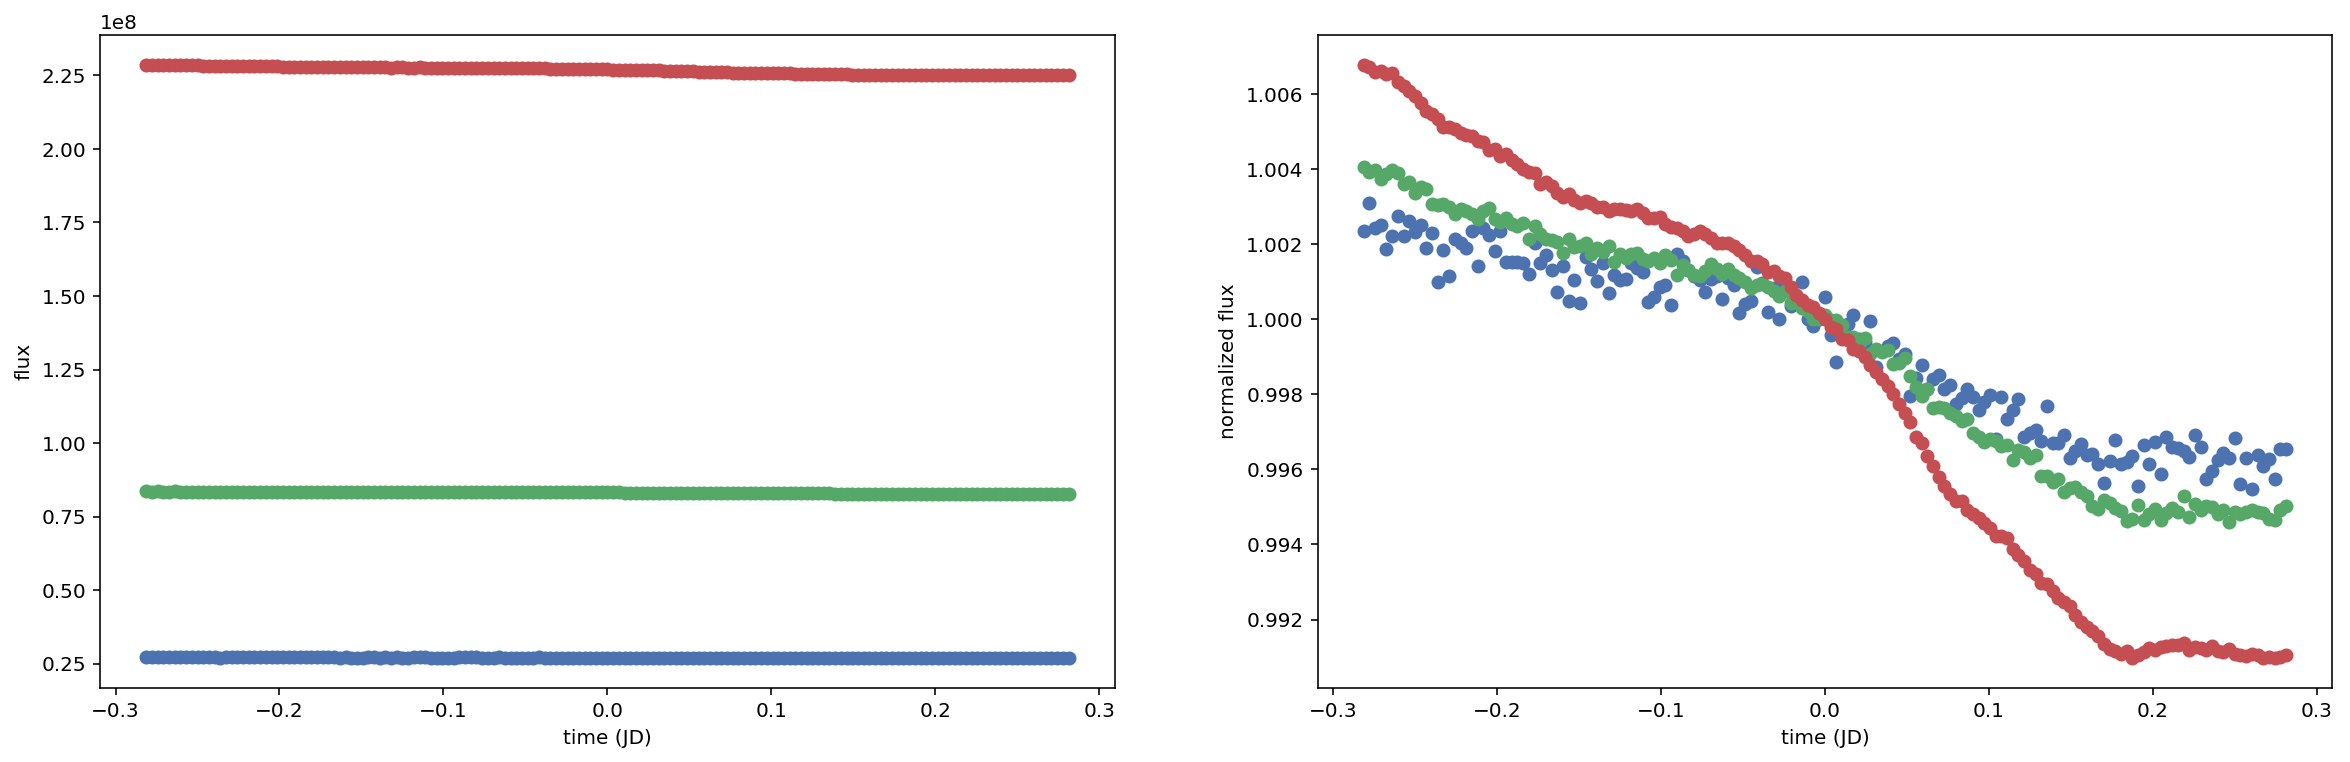

In [12]:
no_transit_model.print_params()
plot_samples(no_transit_model.sample(t), t)

In [ ]:
n = 10
l = np.linspace(-4, 2, n)
a = np.linspace(15, 35, n)

like = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        k1_params = np.exp([l[i], a[j]])
        no_transit_model.update_gp(k1_params=k1_params)
        no_transit_model.gp.compute(t)
        like[i][j] = no_transit_model.gp.log_likelihood([y1, y2, y3])

In [ ]:
fig = pl.figure(figsize=(10, 10))
pl.pcolormesh(a, l, like, vmin=-7.87989e9)
pl.xlabel('log(a)')
pl.ylabel('log(l)')
pl.title('log likelihood')

In [ ]:
n = 5
l = np.linspace(-4, 2, 20)
a = np.linspace(15, 35, n)

for i in range(n):
    like = np.zeros(20)
    for j in range(20):
        k1_params = np.exp([l[j], a[i]])
        no_transit_model.update_gp(k1_params=k1_params)
        no_transit_model.gp.compute(t)
        like[j] = no_transit_model.gp.log_likelihood([y1, y2, y3])
    pl.plot(l, like, linewidth=2, color='k')
pl.ylim(-7.88e9, -7.8798e9)
pl.title('log(wn) = 8')
pl.xlabel('log(l)')
pl.ylabel('log(likelihood)')
pl.show()

In [ ]:
n = 5
l = np.linspace(-4, 2, n)
a = np.linspace(15, 35, 20)
no_transit_model.update_gp(log_white_noise=[10]*3)

for i in range(n):
    like = np.zeros(20)
    for j in range(20):
        log_k1_params = [l[i], a[j]]
        no_transit_model.update_gp(log_k1_params=log_k1_params)
        no_transit_model.gp.compute(t)
        like[j] = no_transit_model.gp.log_likelihood([y1, y2, y3])
    pl.plot(a, like, linewidth=2, color='k')
pl.ylim(-8000, -6500)
pl.title('log(wn) = 10')
pl.xlabel('log(a)')
pl.ylabel('log(likelihood)')

In [ ]:
n = 5
l = np.linspace(-4, 2, n)
a = np.linspace(15, 35, 20)
no_transit_model.update_gp(log_white_noise=[13]*3)

for i in range(n):
    like = np.zeros(20)
    for j in range(20):
        log_k1_params = [l[i], a[j]]
        no_transit_model.update_gp(log_k1_params=log_k1_params)
        no_transit_model.gp.compute(t)
        like[j] = no_transit_model.gp.log_likelihood([y1, y2, y3])
    pl.plot(a, like, linewidth=2, color='k')
pl.ylim(-8000, -7000)
pl.title('log(wn) = 13')
pl.xlabel('log(a)')
pl.ylabel('log(likelihood)')

In [ ]:
# set some bounds and minimize
best_fit, _ = no_transit_model.fit([y1, y2, y3], t, method='Nelder-Mead')

In [ ]:
# print results of minimization and samples from minimized gp

no_transit_model.print_params()
samp = no_transit_model.sample(t)

s1, s2, s3 = samp[0] + np.median(data[0]), samp[1] + np.median(data[1]), samp[2] + np.median(data[2])

plot_samples(samp, t)
plot_samples([s1, s2, s3], t)

In [ ]:
log_offsets = np.log([np.median(data[0]), np.median(data[1]), np.median(data[1])])
no_transit_model.update_gp(offsets=log_offsets)
best_fit, _ = no_transit_model.fit([data[0], data[1], data[2]], t)

In [ ]:
samp = no_transit_model.sample(t)
no_transit_model.print_params()
plot_samples(samp, t)

In [ ]:
# set up transit + variability model

mean_params_transit = [0, 0.1, 0.0, 0.1]
transit_model = model(np.log(no_transit_model.k1_params), no_transit_model.k2_params, np.log(no_transit_model.white_noise), 
                     mean_params_transit, no_transit_model.offsets, transit, 
                      kernel.matern32_kernel, kernel.scale_kernel, 3)
transit_model.set_bounds(mean_params_bounds=[(0, 1), (0, 1), (t.min(), t.max()), (0, (t.max() - t.min()))])

In [ ]:
# minimize transit + variability model 

transit_model.fit_mean([data[0], data[1], data[2]], t, bounds=[(0, 1), (0, 1), (t.min(), t.max()), (0, (t.max() - t.min()))])

In [ ]:
# print results of minimization and plot initial guess & minimized transit model together

transit_model.print_params()
pl.plot(t, transit_model.mean_func(t, transit_model.offsets[0], *transit_model.mean_params))
pl.plot(t, transit_model.mean_func(t, transit_model.offsets[0], *mean_params_transit))

In [ ]:
# plot minimized transit over the data

pl.figure(figsize=(12, 10))
for s in data[:-1]:
    pl.plot(t, s/np.median(s), 'o')
    
planet = transit_model.mean_func(t, transit_model.offsets[0], *transit_model.mean_params)
pl.plot(t, planet/np.median(planet))

In [ ]:
# do mcmc starting with the minimized parameters 

samples = transit_model.do_mcmc(500, 40, 100, [data[0], data[1], data[2]], t, progress=True)

In [ ]:
# plot samples from mcmc 

pl.figure(figsize=(12, 10))
for s in data[:-1]:
    pl.plot(t, s/np.median(s), 'o')
    
for s in samples[np.random.randint(len(samples), size=1000)]:
    planet = transit_model.mean_func(t, s[14], s[7], s[8], s[9], s[10])
    pl.plot(t, planet/np.mean(planet), color='k', alpha=0.01)
    
pl.ylim(0.99, 1.01)

In [ ]:
# corner plot of mcmc results 

import corner
fig = corner.corner(samples)